# General Functions

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

In [4]:
def plot_surface_from_image(image, cmap='inferno'):
    """
    Plot a 3D surface from a grayscale image, treating pixel intensity as the Z-values.

    Parameters:
        image (ndarray): 2D array representing the grayscale image (height map).
    """

    # Create a meshgrid for the image coordinates
    Y, X = np.meshgrid(np.arange(image.shape[1]), np.arange(image.shape[0]))

    # Create the Plotly figure
    fig = go.Figure()

    # Add the 3D surface plot
    fig.add_trace(go.Surface(z=image, x=X, y=Y, colorscale=cmap, opacity=1.0, showscale=False))

    # Update layout for better visualization
    fig.update_layout(
        scene=dict(
            xaxis_title='X',
            yaxis_title='Y',
            zaxis_title='Z',
            aspectmode="cube"
        ),
        title="3D Surface Plot from Grayscale Image",
        margin=dict(l=0, r=0, b=0, t=30)
    )

    # Show the plot
    fig.show()

In [80]:
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_surface_info(z, x, y, K, section=None, levels=20):
    """
    Plot a 3D surface with contour plots and a cross-section.
    """
    if not section:
        section = x.shape[0] // 2

    slice = x[0][section]

    # Create figure
    fig = plt.figure(figsize=(16, 4))

    # Contour Plot
    ax1 = fig.add_subplot(141)
    ax1.contour(x, y, z, levels=levels, cmap="inferno")
    plt.axhline(y=slice, color='r', linestyle='--')
    ax1.set_title("Contour Plot")

    # 3D Surface Plot
    ax2 = fig.add_subplot(142, projection='3d')
    ax2.plot_surface(x, y, z, cmap='inferno')
    ax2.set_title("3D Surface Plot")

    # Cross-section (Fix y=0)
    ax3 = fig.add_subplot(143)
    ax3.plot(x[section], z[section], "r--")
    ax3.set_title(f"Cross-section at y={slice:.4f}")

    # Plot curvature
    ax4 = fig.add_subplot(144)
    contour = ax4.contourf(x, y, K, levels=20, cmap='coolwarm')  # Color by curvature
    ax4.set_title("Curvature Visualization")
    # Create a separate colorbar axis
    divider = make_axes_locatable(ax4)
    cax = divider.append_axes("right", size="5%", pad=0.1)  # Adjust size and padding
    fig.colorbar(contour, cax=cax, label="Gaussian Curvature (K)")

    plt.tight_layout()
    plt.show()

# Obtaining Gaussian Curvature
Reference: https://en.wikipedia.org/wiki/Gaussian_curvature

In [108]:
def gaussian_curvature(z, dx, dy):
    """
    Description:
        Computes the Gaussian curvature of a 2D surface.
    Parameters:
        z -> depth in mm
        dx, dy -> pixel size in mm
    """

    # Compute first-order derivatives
    fx = np.gradient(z, axis=1) / dx # x-derivative
    fy = np.gradient(z, axis=0) / dy # y-derivative

    # Compute second-order derivatives
    fxx = np.gradient(fx, axis=1) / dx
    fyy = np.gradient(fy, axis=0) / dy
    fxy = np.gradient(fx, axis=0) / dy

    # Gaussian curvature formula
    numerator = (fxx * fyy - fxy**2)
    denominator = (1 + fx**2 + fy**2)**2
    K = numerator / denominator

    return K

## Create the surface (Sphere)

**Convex Surface:** The curvature ${\cal K} > 0$ and ${\cal K} = \frac{1}{R^2}$ everywhere.

In [109]:
def create_sphere(R=1, size=100):
    x = np.linspace(-R, R, size)
    y = np.linspace(-R, R, size)
    x, y = np.meshgrid(x, y)

    # Compute z values (z = sqrt(R^2 - x^2 - y^2)) and mask invalid points (outside the sphere)
    z = np.sqrt(R**2 - x**2 - y**2)
    z = np.ma.masked_invalid(z) # Mask the NaN values where x^2 + y^2 > R^2

    return x, y, z

In [112]:
x, y, z = create_sphere(R=10, size=500)
plot_surface_from_image(z)

Output hidden; open in https://colab.research.google.com to view.

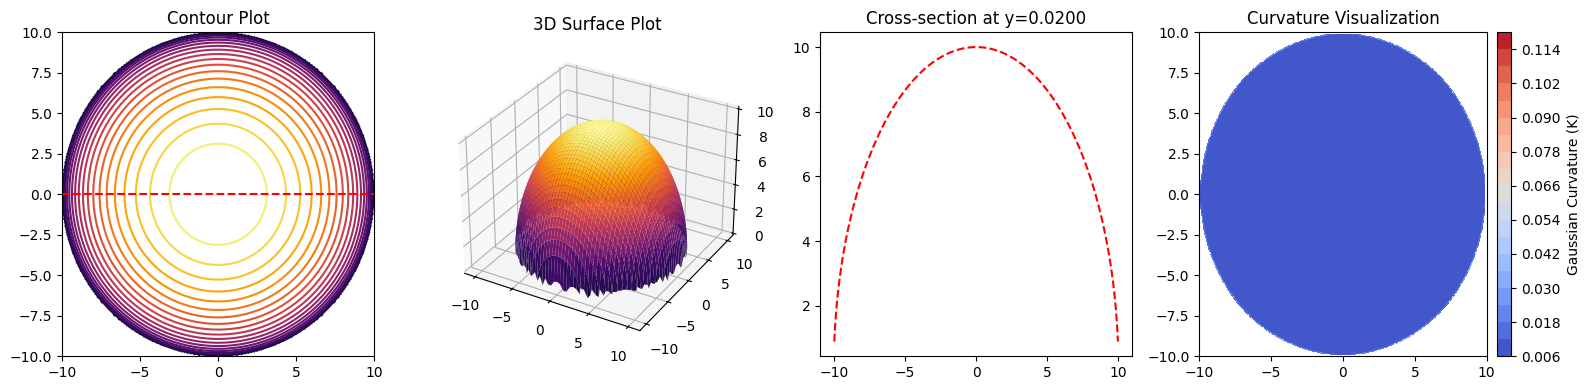

In [113]:
# All the pixels have a constant distance in mm
dx = x[0, 1] - x[0, 0]
dy = y[1, 0] - y[0, 0]

# Compute Gaussian curvature for the spherical surface
K = gaussian_curvature(z, dx, dy)

# Plot
plot_surface_info(z, x, y, K, section=250, levels=20)

## Create the surface (Cylinder)

It is curve in X and flat in Y, then ${\cal K}x \times {\cal K}y = 0$.

In [114]:
def create_cylinder(R=1, size=100):
    x = np.linspace(-R, R, size)
    y = np.linspace(-R, R, size)
    x, y = np.meshgrid(x, y)

    # Compute z values
    z = np.sqrt(R**2 - x**2)
    z = np.ma.masked_invalid(z) # Mask the NaN values

    return x, y, z

In [115]:
x, y, z = create_cylinder(R=10, size=500)
plot_surface_from_image(z)

Output hidden; open in https://colab.research.google.com to view.

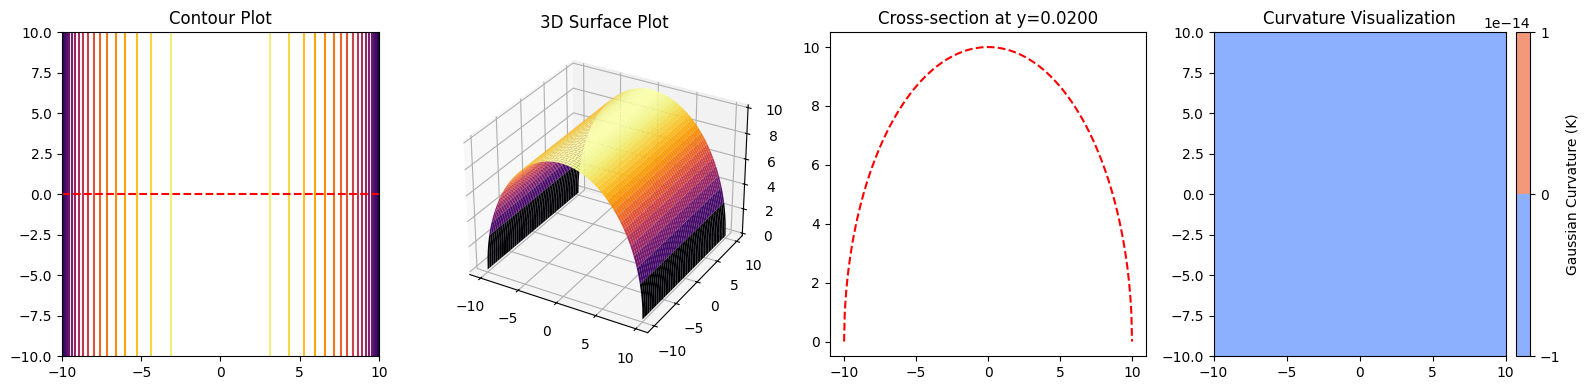

In [116]:
# All the pixels have a constant distance in mm
dx = x[0, 1] - x[0, 0]
dy = y[1, 0] - y[0, 0]

# Compute Gaussian curvature for the spherical surface
K = gaussian_curvature(z, dx, dy)

# Plot
plot_surface_info(z, x, y, K, section=250, levels=20)

## Create the surface (Hiperboloid)

Concave Surface: The curvature ${\cal K} < 0$

In [117]:
def create_hiperboloid(a=0.01, b=0.01, c=0.02, size=100):
    x = np.linspace(-1, 1, size)
    y = np.linspace(-1, 1, size)
    x, y = np.meshgrid(x, y)

    # Obtaining equation (X^2 / b^2 + Y^2 / c^2 - 1)
    part = (x**2 / b**2 + y**2 / c**2 - 1)
    # Remove negative values for square root
    part = np.maximum(part, 0)
    # Compute z values
    z = np.sqrt(part) * a
    z = np.ma.masked_invalid(z) # Mask the NaN values

    return x, y, z

In [118]:
x, y, z = create_hiperboloid(a=0.01, b=0.01, c=0.02, size=500)
plot_surface_from_image(z)

Output hidden; open in https://colab.research.google.com to view.

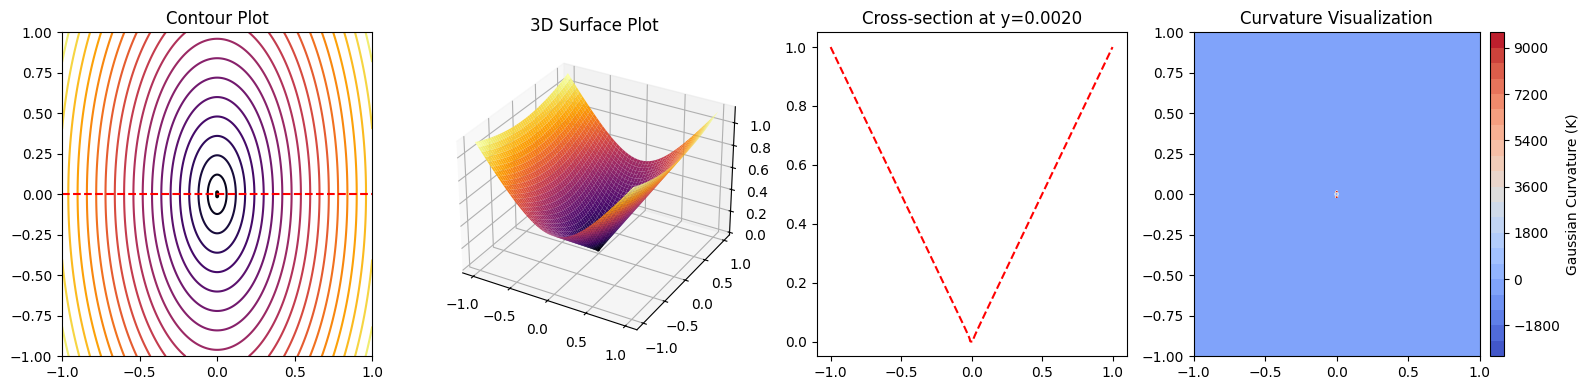

In [119]:
# All the pixels have a constant distance in mm
dx = x[0, 1] - x[0, 0]
dy = y[1, 0] - y[0, 0]

# Compute Gaussian curvature for the spherical surface
K = gaussian_curvature(z, dx, dy)

# Plot
plot_surface_info(z, x, y, K, section=250, levels=20)

## Create the surface (Hyperbolic Paraboloid)

In [120]:
def create_hyperbolic_paraboloid(a=1, b=1, size=100):
    x = np.linspace(-2*a, 2*a, size)
    y = np.linspace(-2*b, 2*b, size)
    x, y = np.meshgrid(x, y)

    # Compute z values (Hyperbolic Paraboloid)
    z = (x**2 / a**2) - (y**2 / b**2)

    return x, y, z

In [121]:
x, y, z = create_hyperbolic_paraboloid(a=1, b=1, size=500)
plot_surface_from_image(z)

Output hidden; open in https://colab.research.google.com to view.

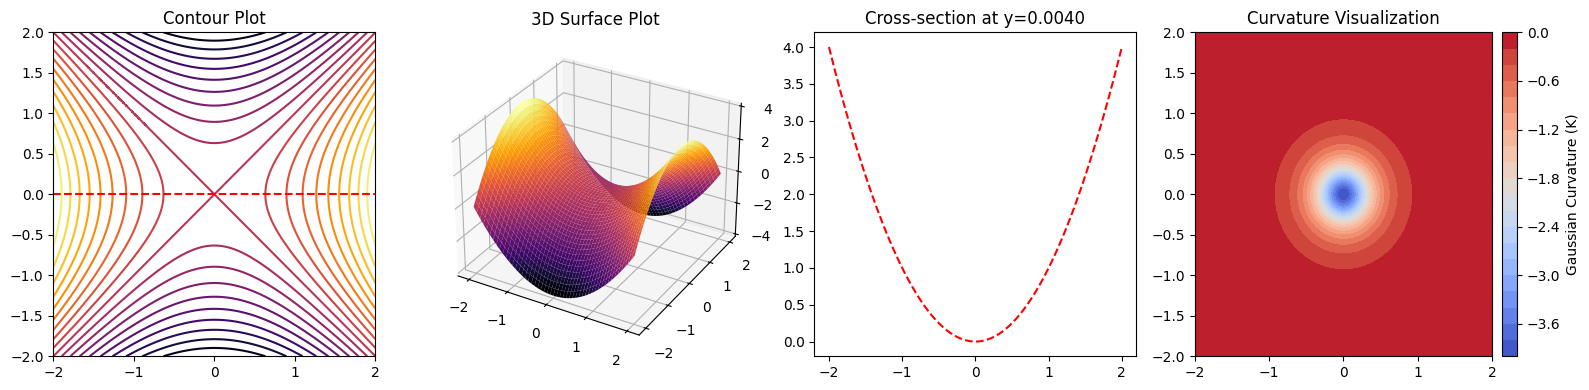

In [122]:
# All the pixels have a constant distance in mm
dx = x[0, 1] - x[0, 0]
dy = y[1, 0] - y[0, 0]

# Compute Gaussian curvature for the spherical surface
K = gaussian_curvature(z, dx, dy)

# Plot
plot_surface_info(z, x, y, K, section=250, levels=20)

## Create the surface (Sines and Cosines)

In [123]:
def create_sines_cosines(a=1, b=1, k=1, size=100):
    x = np.linspace(-2*np.pi, 2*np.pi, size)
    y = np.linspace(-2*np.pi, 2*np.pi, size)
    x, y = np.meshgrid(x, y)

    # Compute z values (Sine-Cosine Ripples)
    z = a * np.cos(k * x) + b * np.sin(k * y)

    return x, y, z

In [124]:
x, y, z = create_sines_cosines(a=1, b=1, k=1, size=500)
plot_surface_from_image(z)

Output hidden; open in https://colab.research.google.com to view.

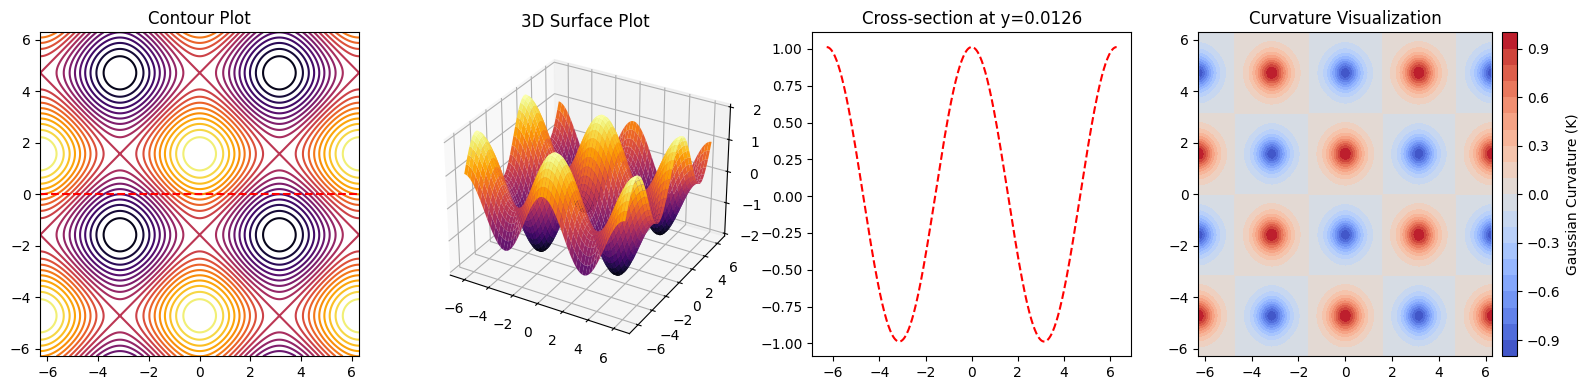

In [125]:
# All the pixels have a constant distance in mm
dx = x[0, 1] - x[0, 0]
dy = y[1, 0] - y[0, 0]

# Compute Gaussian curvature for the spherical surface
K = gaussian_curvature(z, dx, dy)

# Plot
plot_surface_info(z, x, y, K, section=250, levels=20)

## Exploring the equation

Gaussian Curvature $\cal K = \frac{F_{xx} \times F_{yy} - F_{xy}^2}{ 1 + F_{x}^2 + F_{y}^2}$ needs to consider the division by a constant as follows: $\cal K = \frac{\frac{F_{xx}}{\Delta x} \times \frac{F_{yy}}{\Delta y} - (\frac{F_{xy}}{{\Delta y}})^2}{ 1 + (\frac{F_{x}}{{\Delta x}})^2 + (\frac{F_{y}}{{\Delta y}})^2}$, where $F_{x}$ and $F_{y}$ are first derivatives, $F_{xx}, F_{yy}$ and $F_{xy}$ are second derivatives, and $\Delta$ is the constant to transform pixels in milimeters.

In [132]:
# Create a surface
x, y, z = create_sphere(R=10, size=500)
# x, y, z = create_cylinder(R=10, size=500)
# x, y, z = create_hiperboloid(a=0.01, b=0.01, c=0.02, size=500)
# x, y, z = create_hyperbolic_paraboloid(a=1, b=1, size=500)
# x, y, z = create_sines_cosines(a=1, b=1, k=1, size=500)

# All the pixels have a constant distance in mm
dx = x[0, 1] - x[0, 0]
dy = y[1, 0] - y[0, 0]
print(dx, dy)

fx = np.gradient(z, axis=1) / dx
fy = np.gradient(z, axis=0) / dy

fxx = np.gradient(fx, axis=1) / dx
fyy = np.gradient(fy, axis=0) / dy
fxy = np.gradient(fx, axis=0) / dy

# Gaussian curvature formula
numerator = (fxx * fyy - fxy**2)
denominator = (1 + fx**2 + fy**2)**2
K = numerator / denominator

px, py = 400, 300
print(f"x = {x[px-1:px+2, py-1:py+2]}")
print(f"y = {y[px-1:px+2, py-1:py+2]}")
print(f"z = {z[px-1:px+2, py-1:py+2]}")
print(f"fx = {fx[px-1:px+2, py-1:py+2]}")
print(f"fy = {fy[px-1:px+2, py-1:py+2]}")
print(f"fxx = {fxx[px-1:px+2, py-1:py+2]}")
print(f"fyy = {fyy[px-1:px+2, py-1:py+2]}")
print(f"fxy = {fxy[px-1:px+2, py-1:py+2]}")
print(f"K = {K[px-1:px+2, py-1:py+2]}")

0.04008016032064177 0.04008016032064177
x = [[1.98396794 2.0240481  2.06412826]
 [1.98396794 2.0240481  2.06412826]
 [1.98396794 2.0240481  2.06412826]]
y = [[5.99198397 5.99198397 5.99198397]
 [6.03206413 6.03206413 6.03206413]
 [6.07214429 6.07214429 6.07214429]]
z = [[7.756287730443754 7.745925214737067 7.735341147529564]
 [7.725158482648355 7.714754154015602 7.704127263568893]
 [7.693694494073227 7.683247558357068 7.672577029874927]]
fx = [[-0.25579197509789536 -0.2613086218545191 -0.2668476928047342]
 [-0.2568227440866671 -0.2623644580162844 -0.2679288808216647]
 [-0.2578730737742014 -0.26344036587378467 -0.26903065955478156]]
fy = [[-0.7725489212525976 -0.7735824995992364 -0.774641034959657]
 [-0.7808506237223183 -0.7819037633404795 -0.7829823677415839]
 [-0.7892538517586604 -0.7903270682821188 -0.7914262719972436]]
fxx = [[-0.13736796127470086 -0.13792007839281273 -0.13848705881716505]
 [-0.13798994426533576 -0.1385490557690935 -0.13912325031809722]
 [-0.13862457990548485 -0.139

<ipython-input-109-e81e434df38e>:7: RuntimeWarning:

invalid value encountered in sqrt



In [133]:
print(f"Result at [{px},{py}]: {K[px, py]:.6f}")

Result at [400,300]: 0.010001


In [134]:
# See that now the curvature is 1/(R^2) everywhere in the sphere
import plotly.express as pltex
pltex.imshow(K, color_continuous_scale='gray')

Output hidden; open in https://colab.research.google.com to view.